In [1]:
from util import *

import pandas as pd
import numpy as np 
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from xgboost import plot_importance


In [2]:
df = pd.read_csv('preprocess_data.csv')
df

,title,year,rating,runtime,kind,color_info,sound_mix,director_name,genre,director_id,cast_names,cast_ids,votes,country,day,month
0,Miss Jerry,1894,5.9,40.0,movie,Black and White,Silent,['Alexander Black'],"['Short', 'Romance']",['0085156'],"['Blanche Bayliss', 'William Courtenay', 'Chau...","['0063086', '0183823', '1309758']",191.0,USA,0,8.0
1,The Story of the Kelly Gang,1906,6.1,70.0,movie,Black and White,Silent,['Charles Tait'],"['Action', 'Adventure', 'Biography', 'Crime', ...",['0846879'],"['Elizabeth Tait', 'John Tait', 'Nicholas Brie...","['0846887', '0846894', '1431224', '3002376', '...",737.0,Australia,26,12.0
2,Den sorte drøm,1911,5.9,53.0,movie,Black and White,Silent,['Urban Gad'],['Drama'],['0300487'],"['Asta Nielsen', 'Valdemar Psilander', 'Gunnar...","['0003425', '0699637', '0375839', '0016799', '...",218.0,Germany,19,8.0
3,Cleopatra,1963,7.0,192.0,movie,Color,DTS,['Joseph L. Mankiewicz'],"['Biography', 'Drama', 'History', 'Romance']",['0000581'],"['Elizabeth Taylor', 'Richard Burton', 'Rex Ha...","['0000072', '0000009', '0001322', '0114386', '...",31526.0,Canada,31,7.0
4,Torment,1994,7.1,102.0,movie,Color,Dolby,['Claude Chabrol'],"['Crime', 'Drama', 'Thriller']",['0001031'],"['Emmanuelle Béart', 'François Cluzet', 'Natha...","['0000322', '0167388', '0136597', '0932870', '...",4936.0,France,16,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84979,A Second Chance: Rivals!,2019,4.8,89.0,movie,Color,NaN,['Clay Glen'],"['Drama', 'Family', 'Sport']",['4825581'],"['Emily Morris', 'Stella Shute', 'Carmel Johns...","['4825006', '10195787', '0424718', '1138590', ...",338.0,Australia,24,10.0
84980,Feed,2017,6.2,95.0,movie,Color,NaN,['Tommy Bertelsen'],['Drama'],['0077879'],"['Troian Bellisario', 'Tom Felton', 'Ben Winch...","['0069079', '0271657', '3656718', '0001664', '...",2445.0,USA,18,7.0
84981,Capernaum,2018,8.4,126.0,movie,Color,Dolby,['Nadine Labaki'],['Drama'],['1701024'],"['Zain Al Rafeea', 'Yordanos Shiferaw', 'Boluw...","['9862858', '9862859', '9862860', '10201625', ...",78256.0,Lebanon,20,10.0
84982,G-Loc,2020,4.6,92.0,movie,Color,NaN,['Tom Paton'],['Sci-Fi'],['7441188'],"['Stephen Moyer', 'Tala Gouveia', 'John Rhys-D...","['0610459', '4823334', '0722636', '7478548', '...",1597.0,USA,11,8.0


In [3]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df= df[pd.to_numeric(df['rating'], errors='coerce').notnull()]
df = df.dropna(subset = ['cast_names','cast_ids','director_name','director_id'])

# Feature Engineering


In [4]:
# age là tuổi của phim được cho đến năm hiện tại (2021)
df['age'] = 2021 - df['year']
df['age']

0        127
1        115
2        110
3         58
4         27
        ... 
84979      2
84980      4
84981      3
84982      1
84983      2
Name: age, Length: 83099, dtype: int64

In [5]:
# tách 1 chuỗi string thành mảng các string chứa thông tin
df['cast_names'] = df['cast_names'].apply(split_text)
df['cast_ids'] = df['cast_ids'].apply(split_text)
df['director_name'] = df['director_name'].apply(split_text)


In [6]:
#number cast là số lượng thành viên đoàn cast
df['number_cast'] = df['cast_names'].apply(lambda s: len(s))
df['number_cast']

0          3
1         17
2         11
3         85
4         27
        ... 
84979     22
84980     21
84981    115
84982     10
84983     28
Name: number_cast, Length: 83099, dtype: int64

In [7]:
le = preprocessing.LabelEncoder()
df['country'] = le.fit_transform(df['country'])
country_list = list(le.classes_)
df['kind'] = le.fit_transform(df['kind'])
kind_list = list(le.classes_)
df['color_info'] = le.fit_transform(df['color_info'])
color_list = list(le.classes_)
df['sound_mix'] = le.fit_transform(df['sound_mix'])
sound_list = list(le.classes_)


In [8]:
df = df.reset_index(drop = True)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 1)

In [10]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [11]:
# xây dựng dict chứa thông tin về điểm trung bình của đạo diễn và các diễn viên
cast_score_board = getScoreBroad(X_train['cast_ids'], y_train)
director_score_board = getScoreBroad(X_train['director_id'], y_train)

Xây dựng dict bằng tập train và sau đó mapping sang tập test

In [12]:
for i in X_train.index:
    s = df['cast_ids'][i]
    me, ma, mi = getScore(s, cast_score_board)
    X_train.loc[i,'cast_mean_score'] = me
    X_train.loc[i,'cast_max_score'] = ma
    X_train.loc[i,'cast_min_score'] = mi
    
    s = df.loc[i,'director_id']
    me, ma, mi = getScore(s, director_score_board)
    X_train.loc[i,'director_mean_score'] = me
    X_train.loc[i,'director_max_score'] = ma
    X_train.loc[i,'director_min_score'] = mi

    
for i in X_test.index:
    s = df['cast_ids'][i]
    me, ma, mi = getScore(s, cast_score_board)
    X_test.loc[i,'cast_mean_score'] = me
    X_test.loc[i,'cast_max_score'] = ma
    X_test.loc[i,'cast_min_score'] = mi
    
    s = df['director_id'][i]
    me, ma, mi = getScore(s, director_score_board)
    X_test.loc[i,'director_mean_score'] = me
    X_test.loc[i,'director_max_score'] = ma
    X_test.loc[i,'director_min_score'] = mi

# Visualize 


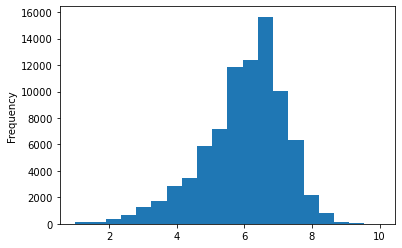

In [13]:
df.rating.plot.hist(bins = 20);

phân bố của rating tập trung chủ yếu ở 6 đến 7 điểm 

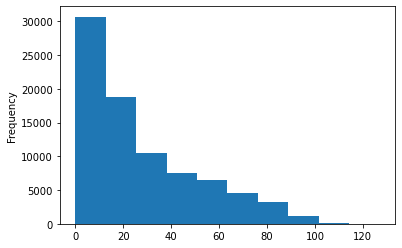

In [14]:
df.age.plot.hist();

Số lượng phim tập trung vào 20 năm đổ lại

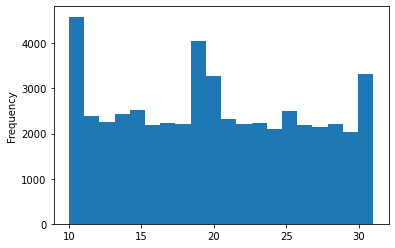

In [15]:
df[df['day']!=0].day.plot.hist(bins = 20);

Phim chủ yếu được release vào cuối tháng, tập trung chủ yếu vào ngày 19 đến 20

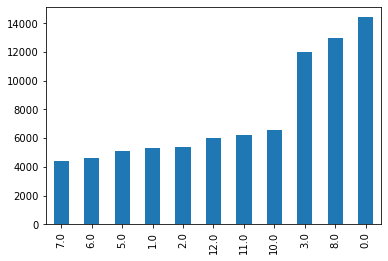

In [16]:
df.month.value_counts().sort_values().plot.bar(); 

Phim được phát hành tập trung vào các tháng đầu và cuối năm

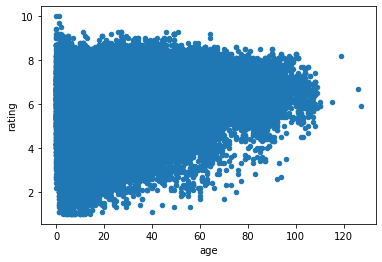

In [17]:
df.plot.scatter(x='age', y='rating');

Có thể dễ dàng thấy được số lượng phim có tuổi đời lớn hơn 70 có rating cao hơn và số lượng ít hơn.

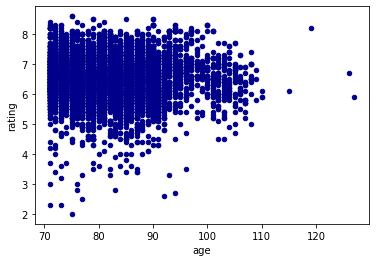

In [18]:
case = df[df['age']>70]
case.plot.scatter(x='age', y='rating', c='DarkBlue');

In [19]:
print('Rating trung bình của các bộ phim có tuổi đời lớn hơn 70:',round(case.rating.mean(),3))
print('Rating trung bình của tất cả phim:',round(df.rating.mean(),3))

Rating trung bình của các bộ phim có tuổi đời lớn hơn 70: 6.496
Rating trung bình của tất cả phim: 5.971


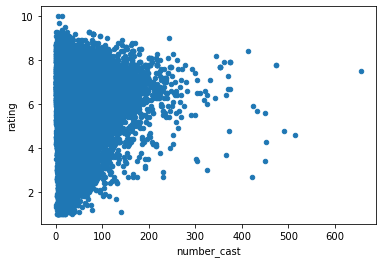

In [20]:
df.plot.scatter(x= 'number_cast', y='rating');

Với number cast lớn thì phim có xu hướng điểm cao hơn

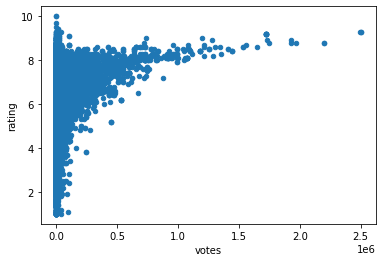

In [21]:
df.plot.scatter(x= 'votes', y='rating');

Số vote càng cao thì tỉ lệ rate càng cao

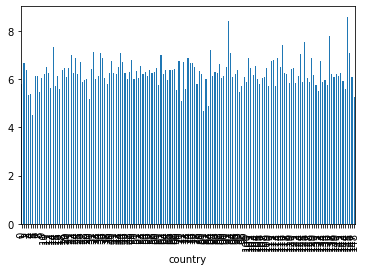

In [22]:
df.groupby('country').rating.mean().plot.bar();

Rating trung bình phim của các nước không cách biệt nhau quá nhiều

# Train Model


In [23]:
select_feature = ['runtime', 'kind', 'color_info', 'sound_mix','votes',
                  'country', 'day', 'month', 'number_cast','cast_mean_score',
                  'cast_min_score', 'cast_max_score', 'director_mean_score', 
                  'director_max_score', 'director_min_score']

In [24]:
X_train = X_train[select_feature]
X_test = X_test[select_feature]

evalset = [(X_train, y_train), (X_test,y_test)]

In [30]:
X_train

,runtime,kind,color_info,sound_mix,votes,country,day,month,number_cast,cast_mean_score,cast_min_score,cast_max_score,director_mean_score,director_max_score,director_min_score
0,87.0,1,1,2,7037.0,48,17,3.0,21,5.900000,5.9,5.9,5.900000,5.9,5.9
1,108.0,1,1,1,308.0,59,29,3.0,27,6.100000,6.1,6.1,6.100000,6.1,6.1
2,78.0,1,1,5,723.0,67,23,11.0,17,6.076364,6.5,7.4,5.900000,5.9,5.9
3,106.0,1,0,2,188.0,85,31,8.0,41,6.564227,6.5,7.7,7.435714,8.2,6.5
4,103.0,1,1,5,366.0,134,24,1.0,14,6.700352,6.5,7.1,6.503846,7.7,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74784,101.0,1,1,2,66914.0,136,19,7.0,96,6.082758,6.5,8.6,6.400000,6.4,6.4
74785,82.0,1,1,5,792.0,31,22,12.0,8,7.138832,6.5,8.3,6.833333,7.4,6.5
74786,157.0,1,1,5,1185.0,59,27,3.0,16,3.870000,3.7,7.1,3.700000,3.7,3.7
74787,83.0,1,0,2,7143.0,136,20,7.0,31,5.178972,4.9,7.1,4.700000,4.9,4.9


In [31]:
model = XGBRegressor(n_estimators = 500,
                     max_depth=3);
model.fit(X_train,y_train, eval_metric='rmse', eval_set=evalset);

[0]	validation_0-rmse:3.99822	validation_1-rmse:3.99804
[1]	validation_0-rmse:2.90159	validation_1-rmse:2.90351
[2]	validation_0-rmse:2.16804	validation_1-rmse:2.16940
[3]	validation_0-rmse:1.69323	validation_1-rmse:1.69470
[4]	validation_0-rmse:1.39946	validation_1-rmse:1.40220
[5]	validation_0-rmse:1.22850	validation_1-rmse:1.23144
[6]	validation_0-rmse:1.13380	validation_1-rmse:1.13666
[7]	validation_0-rmse:1.08016	validation_1-rmse:1.08413
[8]	validation_0-rmse:1.05252	validation_1-rmse:1.05699
[9]	validation_0-rmse:1.03727	validation_1-rmse:1.04097
[10]	validation_0-rmse:1.02878	validation_1-rmse:1.03259
[11]	validation_0-rmse:1.02272	validation_1-rmse:1.02696
[12]	validation_0-rmse:1.01854	validation_1-rmse:1.02330
[13]	validation_0-rmse:1.01563	validation_1-rmse:1.02099
[14]	validation_0-rmse:1.01361	validation_1-rmse:1.01942
[15]	validation_0-rmse:1.01252	validation_1-rmse:1.01841
[16]	validation_0-rmse:1.01119	validation_1-rmse:1.01762
[17]	validation_0-rmse:1.00934	validation

[144]	validation_0-rmse:0.97035	validation_1-rmse:0.99402
[145]	validation_0-rmse:0.97015	validation_1-rmse:0.99412
[146]	validation_0-rmse:0.97007	validation_1-rmse:0.99405
[147]	validation_0-rmse:0.96989	validation_1-rmse:0.99403
[148]	validation_0-rmse:0.96977	validation_1-rmse:0.99403
[149]	validation_0-rmse:0.96966	validation_1-rmse:0.99403
[150]	validation_0-rmse:0.96959	validation_1-rmse:0.99401
[151]	validation_0-rmse:0.96949	validation_1-rmse:0.99391
[152]	validation_0-rmse:0.96926	validation_1-rmse:0.99394
[153]	validation_0-rmse:0.96916	validation_1-rmse:0.99403
[154]	validation_0-rmse:0.96907	validation_1-rmse:0.99408
[155]	validation_0-rmse:0.96866	validation_1-rmse:0.99413
[156]	validation_0-rmse:0.96852	validation_1-rmse:0.99404
[157]	validation_0-rmse:0.96828	validation_1-rmse:0.99405
[158]	validation_0-rmse:0.96800	validation_1-rmse:0.99398
[159]	validation_0-rmse:0.96790	validation_1-rmse:0.99400
[160]	validation_0-rmse:0.96783	validation_1-rmse:0.99430
[161]	validati

[286]	validation_0-rmse:0.95284	validation_1-rmse:0.99228
[287]	validation_0-rmse:0.95277	validation_1-rmse:0.99225
[288]	validation_0-rmse:0.95268	validation_1-rmse:0.99230
[289]	validation_0-rmse:0.95230	validation_1-rmse:0.99208
[290]	validation_0-rmse:0.95222	validation_1-rmse:0.99212
[291]	validation_0-rmse:0.95216	validation_1-rmse:0.99213
[292]	validation_0-rmse:0.95210	validation_1-rmse:0.99217
[293]	validation_0-rmse:0.95202	validation_1-rmse:0.99219
[294]	validation_0-rmse:0.95190	validation_1-rmse:0.99236
[295]	validation_0-rmse:0.95178	validation_1-rmse:0.99243
[296]	validation_0-rmse:0.95168	validation_1-rmse:0.99250
[297]	validation_0-rmse:0.95156	validation_1-rmse:0.99248
[298]	validation_0-rmse:0.95146	validation_1-rmse:0.99246
[299]	validation_0-rmse:0.95141	validation_1-rmse:0.99237
[300]	validation_0-rmse:0.95131	validation_1-rmse:0.99221
[301]	validation_0-rmse:0.95129	validation_1-rmse:0.99221
[302]	validation_0-rmse:0.95119	validation_1-rmse:0.99219
[303]	validati

[428]	validation_0-rmse:0.93784	validation_1-rmse:0.99014
[429]	validation_0-rmse:0.93772	validation_1-rmse:0.99013
[430]	validation_0-rmse:0.93760	validation_1-rmse:0.99011
[431]	validation_0-rmse:0.93749	validation_1-rmse:0.99014
[432]	validation_0-rmse:0.93734	validation_1-rmse:0.99009
[433]	validation_0-rmse:0.93724	validation_1-rmse:0.99002
[434]	validation_0-rmse:0.93706	validation_1-rmse:0.99012
[435]	validation_0-rmse:0.93697	validation_1-rmse:0.99006
[436]	validation_0-rmse:0.93689	validation_1-rmse:0.99005
[437]	validation_0-rmse:0.93679	validation_1-rmse:0.99005
[438]	validation_0-rmse:0.93673	validation_1-rmse:0.99008
[439]	validation_0-rmse:0.93665	validation_1-rmse:0.99004
[440]	validation_0-rmse:0.93660	validation_1-rmse:0.99002
[441]	validation_0-rmse:0.93650	validation_1-rmse:0.98984
[442]	validation_0-rmse:0.93649	validation_1-rmse:0.98984
[443]	validation_0-rmse:0.93639	validation_1-rmse:0.98998
[444]	validation_0-rmse:0.93634	validation_1-rmse:0.98997
[445]	validati

# Evaluation


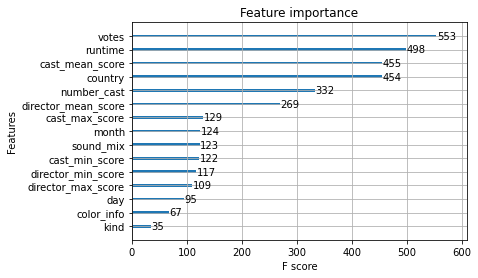

In [32]:
plot_importance(model)
pyplot.show()

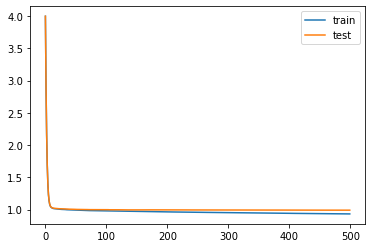

In [33]:
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [35]:
df = pd.read_csv('1_movie_preprocessing.csv')
predict(df)

array([7.181356], dtype=float32)